# Loan Interest Rates

## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from math import sqrt

## Load and Clean the Data

### Loading data

In [2]:
# load the data
df = pd.read_csv("data/LoanData.csv")
df.head()

,LoanId,NewCreditCustomer,LoanDate,VerificationType,Age,Gender,Country,AppliedAmount,Amount,Interest,...,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,Rating,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,False,2022-09-09,By Bank Statement,27,Female,EE,3189.0,3189.0,35.48,...,UpTo5Years,Other,900.0,0,0.00,0,D,1.0,3402.0,0.0
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,False,2023-05-19,By Bank Statement,35,Female,FI,4146.0,4146.0,19.86,...,UpTo5Years,Owner,3100.0,0,0.00,0,B,1.0,518.0,0.0
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,False,2024-02-03,By Bank Statement,23,Male,EE,531.0,531.0,19.52,...,UpTo5Years,TenantFurnished,1700.0,0,0.00,0,B,3.0,1593.0,0.0
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,False,2016-03-23,By Bank Statement,53,Female,EE,2125.0,2125.0,20.97,...,MoreThan5Years,Owner,354.0,8,485.09,6,C,1.0,500.0,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,False,2023-09-26,By Bank Statement,43,Male,FI,414.0,414.0,19.89,...,Other,TenantFurnished,1200.0,0,0.00,0,D,5.0,11198.0,0.0


### Cleaning data

#### Set the Index

Since the loan ID is unique identifier for each loan, set the "LoanId" column as index

In [3]:
# set the "LoanId" column as index
df.set_index("LoanId", inplace=True)

In [4]:
# check the index is correct
df.index.name

'LoanId'

## Retrieving key metrics

### Describing the dataset

#### descriptive statistics

In [5]:
# Sample mean and std of "Interest"
interest_mean = df['Interest'].mean()
interest_std = df['Interest'].std()

# Number of borrowers receiving less than applied
num_less_amount = (df['Amount'] < df['AppliedAmount']).sum()

# Proportion of each rating
rating_proportion = df['Rating'].value_counts() / len(df)

In [6]:
# print the results
print("Interest rate mean:", round(interest_mean, 2))
print("Interest rate standard deviation:", round(interest_std,2))
print("Number of borrowers that received less money than they asked for:", num_less_amount)
print("Proportion of loan ratings:\n", rating_proportion.sort_index())

Interest rate mean: 27.29
Interest rate standard deviation: 18.03
Number of borrowers that received less money than they asked for: 10543
Proportion of loan ratings:
 Rating
A     0.043291
AA    0.024826
B     0.179124
C     0.317741
D     0.206457
E     0.115707
F     0.074443
HR    0.038411
Name: count, dtype: float64


### High-Risk Customers
Customers with a high debt-to-income ratio and less job stability.

#### Identifying High-Risk Customers

Identifying these customers and adding a flag to their loans. Borrowers with less than 1 year on their current job (including those in a trial period) are deemed to have lower job stability. In this scenario, a loan‑to‑rate ratio above 0.35 is considered risky.

In [7]:
# Debt-to-income ratio
df["DebtToIncome"] = df["Amount"] / df["IncomeTotal"]

# Check risk conditions
employment_conditions = df["EmploymentDurationCurrentEmployer"].isin(["TrialPeriod", "UpTo1Year"])
debt_condition = df["DebtToIncome"] >= 0.35

# Create "IsRisky" column
df["IsRisky"] = employment_conditions & debt_condition

# Calculate metrics
risky_proportion = df["IsRisky"].mean()
mean_interest_risky = df.loc[df["IsRisky"], "Interest"].mean()
mean_interest_non_risky = df.loc[~df["IsRisky"], "Interest"].mean()

In [8]:
# print the results
print("Risky loans proportion:", round(risky_proportion, 4))
print("Mean interest rate of risky loans:", round(mean_interest_risky, 4))
print("Mean interest rate of non-risky loans:", round(mean_interest_non_risky, 4))

Risky loans proportion: 0.1588
Mean interest rate of risky loans: 28.8592
Mean interest rate of non-risky loans: 26.9899


## Understanding various customer profiles
Understanding customer profiles allows identifying patterns and how different factors of the borrowers influence loan applications.

### Visualization of different profiles
Visualize to uncover actionable patterns for tailoring loan offers.

#### Segmentation using box plots

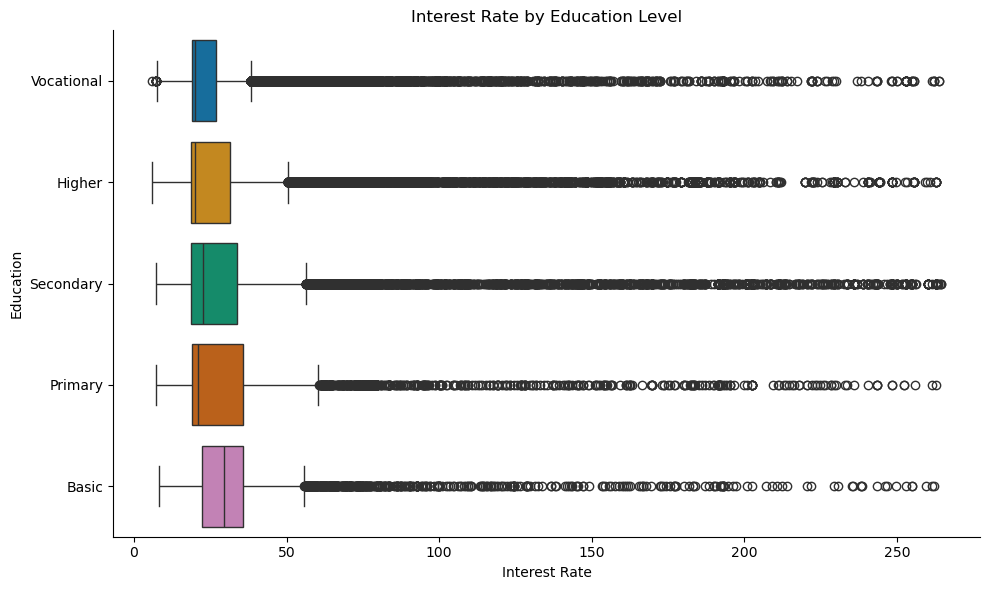

In [9]:
plt.figure(figsize=(10,6))

# Create boxplot
boxplot_ax = sns.boxplot(
    data=df, 
    x='Interest', 
    y='Education', 
    hue='Education',
    palette='colorblind'
)

# Format plot
plt.xlabel("Interest Rate")
plt.title("Interest Rate by Education Level")
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()

#### Scatter plots and correlation
Plots and correlation between features are crucial to investigate the relationship between certain numerical features and the interest rate.

Correlation between Interest Rate and LoanDuration:
-0.0106
Correlation between Interest Rate and IncomeTotal:
-0.0122
Correlation between Interest Rate and AmountOfPreviousLoansBeforeLoan:
-0.175
Correlation between Interest Rate and DebtToIncome:
-0.0053


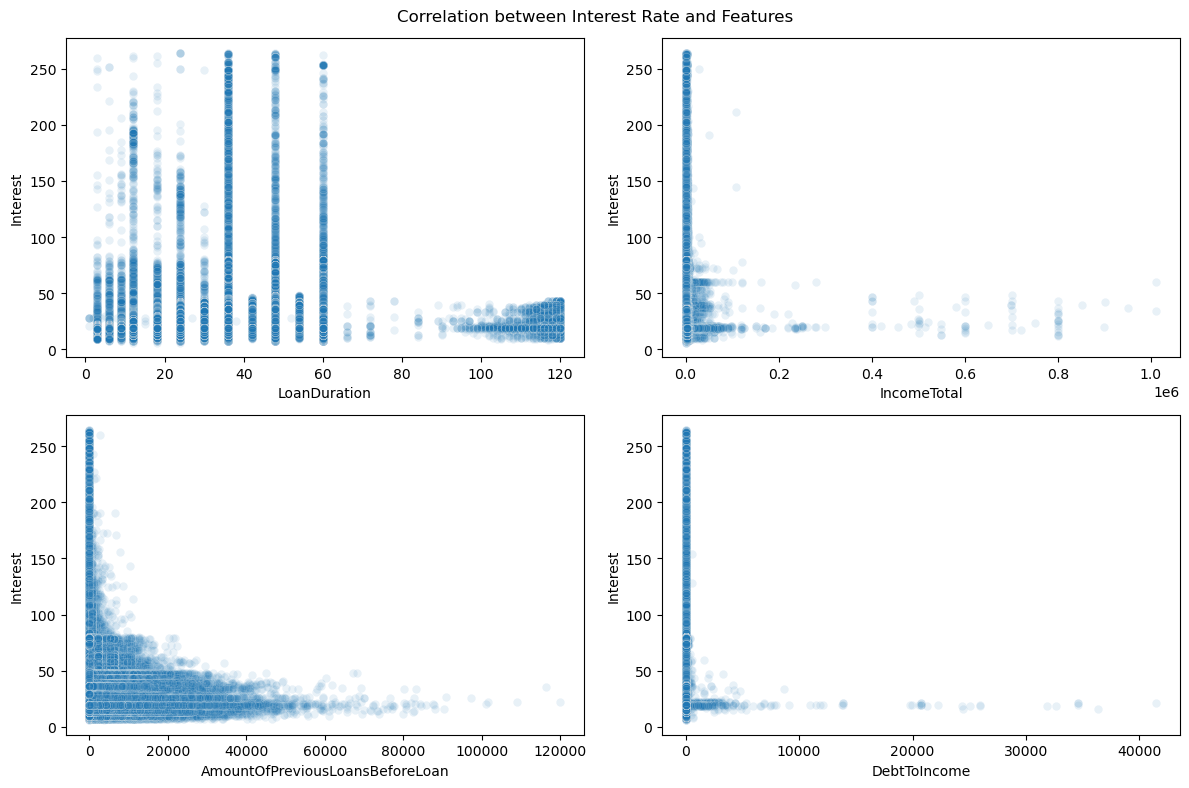

In [10]:
scatterplot_fig = plt.figure(figsize=(12, 8))

# create a list to store the correlation values
correlation = []

# create a list of segmentation columns
corr_columns = ["LoanDuration", "IncomeTotal", "AmountOfPreviousLoansBeforeLoan", 
               "DebtToIncome"]

# iterate over the values 1-4 (one for each subplot)
for i in range(1,5):

    # get the column name. Remember subtract 1 from i to match the list's indexing
    column_name = corr_columns[i-1]

    # create the subplot. Remember the arguments are (rows, columns, index)
    plt.subplot(2,2,i)

    # create scatter plot
    sns.scatterplot(data=df, x=column_name, y='Interest', alpha=0.1)

    # calculate the correlation between the column and the interest rate
    corr = df[column_name].corr(df['Interest'])

    # append the correlation value to the list
    correlation.append(corr)

    # print the results
    print("Correlation between Interest Rate and " + column_name+ ":\n"+ str(round(corr,4))) 

# set the general title
plt.suptitle("Correlation between Interest Rate and Features")

plt.tight_layout()
plt.show()

#### Correlation Heatmap of Numerical Features

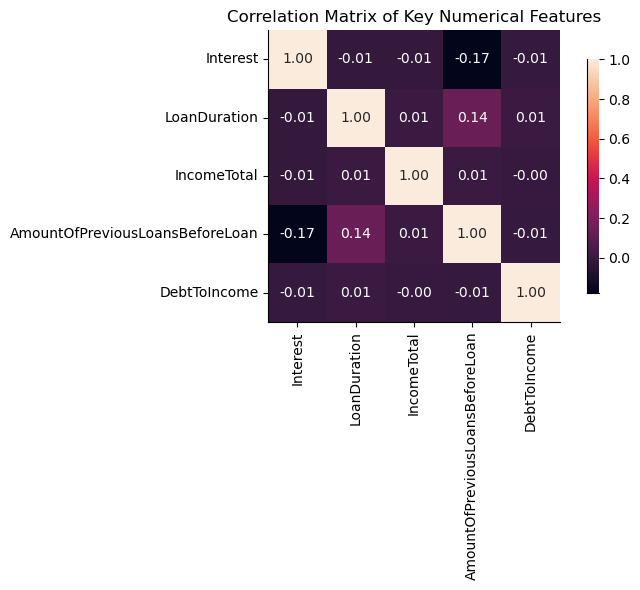

In [11]:
# select numeric columns of interest
num_cols = ['Interest', 'LoanDuration', 'IncomeTotal',
            'AmountOfPreviousLoansBeforeLoan', 'DebtToIncome']
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cbar_kws={'shrink': 0.8},
    square=True
)
plt.title("Correlation Matrix of Key Numerical Features")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

### Applied and Received Amounts
Since there are two similar columns, "AppliedAmount" and "Amount", in the dataset. This implies that sometimes borrowers get loaned a different amount than what they requested for.

#### Confidence Intervals
If more than 5% of loans are approved for less than requested, we might need to revise how loan amounts are communicated to applicants. To estimate this proportion using a confidence interval to support your recommendation.

In [12]:
# Get number of samples where "Amount" < "AppliedAmount"
num_differences = (df['Amount'] < df['AppliedAmount']).sum()

# Total number of samples
n = len(df)

# Sample proportion
phat = num_differences / n

# Standard error
se = sqrt(phat * (1 - phat) / n)

# Calculate confidence interval and convert numpy floats to Python floats
confidence_interval = tuple(map(float, stats.norm.interval(0.95, loc=phat, scale=se)))

In [13]:
# print the results
print("The 95% confidence interval is", confidence_interval)

The 95% confidence interval is (0.02698232853687249, 0.028017645379482474)


## Modelling the Interest Rate
Build a model to predict interest rates using different customer features, to make personalized loan offers. This will help in both predicting interest rates for new customers and observing which features are statistically significant in determining the interest rates.

### Simple Linear Regression
First, create a simple linear regression. Based on the correlation analysis, a good candidate for the independent variable is "AmountOfPreviousLoansBeforeLoan", which presented the strongest correlation with the target variable "Interest". 

#### Training the Linear Regression

In [14]:
# prepare predictors with constant term
X_simple = sm.add_constant(df['AmountOfPreviousLoansBeforeLoan'])

# select the dependent variable
Y_simple = df['Interest']

# build the model
model_simple = sm.OLS(Y_simple, X_simple)

# fit the model
results_simple = model_simple.fit()

# Print the results summary
print(results_simple.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Sat, 12 Jul 2025   Prob (F-statistic):               0.00
Time:                        23:40:17   Log-Likelihood:            -1.6468e+06
No. Observations:              383382   AIC:                         3.294e+06
Df Residuals:                  383380   BIC:                         3.294e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

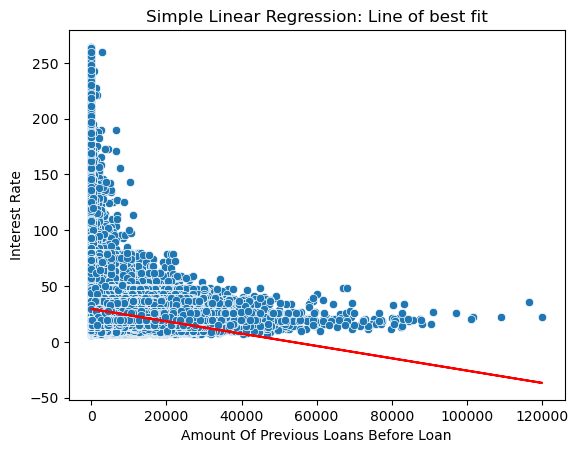

In [15]:
plt.figure()
sns.scatterplot(data=df, x="AmountOfPreviousLoansBeforeLoan", y="Interest")
plt.plot(df["AmountOfPreviousLoansBeforeLoan"], results_simple.predict(X_simple), color="red")
plt.title("Simple Linear Regression: Line of best fit")
plt.xlabel("Amount Of Previous Loans Before Loan")
plt.ylabel("Interest Rate")
plt.show()

### Building a More Complex Linear Regression Model
Since predicting the interest rate using a single variable didn’t yield strong results, a more comprehensive approach is to build a more complex model that includes multiple variables possibly even some categorical ones.

#### Building and refining the model
To decide on which variables to use as predictors and categorical, iterate until you are satisfied with the result

In [16]:
# define a list with the column to be used as predictors
# include numerical and categorical variables
predictors = ['LoanDuration', 'DebtToIncome', 'Rating', 'EmploymentDurationCurrentEmployer']
categorical = ['Rating', 'EmploymentDurationCurrentEmployer']

# create the predictors dataframe with constant term
X = pd.get_dummies(df[predictors], columns=categorical, drop_first=True, dtype=int)
X = sm.add_constant(X)

# create the target variable
Y = df['Interest']

# create the model
model = sm.OLS(Y, X)

# fit the model
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 3.422e+04
Date:                Sat, 12 Jul 2025   Prob (F-statistic):               0.00
Time:                        23:40:21   Log-Likelihood:            -1.4758e+06
No. Observations:              383382   AIC:                         2.952e+06
Df Residuals:                  383364   BIC:                         2.952e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------